In [17]:
import os
import pathlib
import sys
import cv2

import numpy as np
import pandas as pd
from enum import Enum, auto

# Divers utilitaires
from collections import defaultdict
from tqdm import tqdm 

# Bibliothèques Keras / Tensorflow
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.mixed_precision import set_global_policy
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## keras tuner
from keras_tuner import Hyperband

# Outils de machine learning classique
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Visualisation des données
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [2]:
def plot_confusion_matrix(cm, labels, normalize=False, title="Matrice de confusion", cmap="coolwarm"):
    """
    Affiche une matrice de confusion à l'aide de Seaborn.

    Args:
        cm (array): Matrice de confusion.
        labels (list): Liste des noms de classes (ordonnées et abscisses).
        normalize (bool): Si True, normalise par ligne et affiche les pourcentages.
        title (str): Titre du graphique.
        cmap (str): Palette de couleurs.
    """
    if normalize:
        # Normalisation ligne par ligne
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = ".2%"  # Affichage sous forme de pourcentage XX.XX%
    else:
        fmt = "d"  # Entiers bruts

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=labels, yticklabels=labels)

    plt.title(title)
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.tight_layout()


In [3]:
def epoch_viewer(model, style="whitegrid", engine="seaborn"):
    """
    Affiche les courbes d'apprentissage (accuracy et perte) à partir de l'historique du modèle.

    Args:
        model: objet Keras avec un attribut .history contenant les métriques.
        style: style graphique pour Seaborn.
        engine: "seaborn" (par défaut) ou "plotly" pour une visualisation interactive.
    """
    history = model.history

    if engine == "plotly": 
        if "plotly" not in sys.modules:
            print("Plotly non installé, utilisation de Seaborn")
        else:
            fig = make_subplots(rows=1, cols=2, subplot_titles=["Accuracy", "Loss"])

            # Accuracy
            fig.add_trace(go.Scatter(x=list(range(len(history["accuracy"]))), y=history["accuracy"],
                                     mode="lines", name="Train Accuracy"), row=1, col=1)
            fig.add_trace(go.Scatter(x=list(range(len(history["val_accuracy"]))), y=history["val_accuracy"],
                                     mode="lines", name="Validation Accuracy"), row=1, col=1)

            # Loss
            fig.add_trace(go.Scatter(x=list(range(len(history["loss"]))), y=history["loss"],
                                     mode="lines", name="Train Loss"), row=1, col=2)
            fig.add_trace(go.Scatter(x=list(range(len(history["val_loss"]))), y=history["val_loss"],
                                     mode="lines", name="Validation Loss"), row=1, col=2)

            fig.update_layout(height=600, width=1500, title_text="Historique d'entraînement", template="plotly_white")
            fig.show()
            return
        
    # Affichage classique avec seaborn
    sns.set_theme(style=style)
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    sns.lineplot(model.history['accuracy'], color="blue", label="acc", ax=ax[0])
    sns.lineplot(model.history['val_accuracy'], color="red", label="val acc", ax=ax[0])
    ax[0].legend()
    ax[0].set_title("Accuracy")

    sns.lineplot(model.history['loss'], color="blue", label="loss", ax=ax[1])
    sns.lineplot(model.history['val_loss'], color="red", label="val loss", ax=ax[1])
    ax[1].legend()
    ax[1].set_title("Los_accuracy")


In [4]:
def define_paths(data_dir, exclude_dirs=None, exclude_files=None):
    """
    Définit les chemins de fichiers et leurs étiquettes (labels) à partir d’un
    dossier principal. Possibilité d’exclure certains dossiers ou fichiers.

    Arguments :
        data_dir (str) : Chemin vers le dossier de données principal.
        exclude_dirs (list, optionnel) : Liste de noms de dossiers à exclure.
                                         Exemple : ['a_exclure'].
        exclude_files (list, optionnel) : Liste de fichiers à exclure (noms simples, sans chemin).
                                          Exemple : ['image_bug.jpg'].

    Retourne :
        tuple :
            - filepaths (list) : Liste des chemins absolus vers les fichiers valides.
            - labels (list) : Liste des étiquettes correspondantes (noms des dossiers parents).
    """
    filepaths = []
    labels = []

    # Si aucune liste d'exclusion n'est fournie, on utilise des listes vides
    if exclude_dirs is None:
        exclude_dirs = []
    if exclude_files is None:
        exclude_files = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)

        # Sauter les dossiers explicitement exclus
        if fold in exclude_dirs:
            print(f"Dossier exclu : {foldpath}")
            continue

        # Sauter les fichiers à la racine du dossier (on attend uniquement des sous-dossiers)
        if pathlib.Path(foldpath).suffix != '':
            continue

        # Liste des fichiers dans le dossier courant
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            file_basename = os.path.basename(fpath)

            # Exclure certains fichiers spécifiquement
            if file_basename in exclude_files:
                print(f"Fichier exclu : {fpath}")
                continue

            # Si on tombe sur un sous-dossier (par exemple "masks")
            if pathlib.Path(fpath).suffix == '':
                if pathlib.Path(fpath).parts[-1].lower() == 'masks':
                    print(f"Dossier de masques ignoré : {fpath}")
                    continue
                else:
                    # Parcours du contenu du sous-dossier
                    o_file = os.listdir(fpath)
                    for f in o_file:
                        ipath = os.path.join(fpath, f)
                        inner_file_basename = os.path.basename(ipath)

                        # Exclusion spécifique de fichiers internes
                        if inner_file_basename in exclude_files:
                            print(f"Fichier exclu (interne) : {ipath}")
                            continue

                        filepaths.append(ipath)
                        labels.append(fold)  # Étiquette = nom du dossier parent
            else:
                # Fichier directement dans le dossier principal
                filepaths.append(fpath)
                labels.append(fold)

    return filepaths, labels



def define_df(files, classes):
    """
    Crée un DataFrame pandas à partir de deux listes : les chemins et les labels.

    Arguments :
        files (list) : Liste des chemins vers les fichiers.
        classes (list) : Liste des étiquettes associées.

    Retourne :
        pd.DataFrame : Un tableau avec deux colonnes : 'filepaths' et 'labels'.
    """
    Fseries = pd.Series(files, name="filepaths")
    Lseries = pd.Series(classes, name="labels")
    return pd.concat([Fseries, Lseries], axis=1)



def split_data(data_dir, exclude_dirs=None, exclude_files=None):
    """
    Divise l'ensemble des données en trois sous-ensembles : entraînement, validation et test.

    Arguments :
        data_dir (str) : Chemin vers le dossier principal contenant les données.
        exclude_dirs (list, optionnel) : Dossiers à ignorer.
        exclude_files (list, optionnel) : Fichiers à ignorer.

    Retourne :
        tuple :
            - train_df : Données pour l'entraînement.
            - valid_df : Données pour la validation.
            - test_df : Données pour le test final.
    """
    # Création des chemins de fichiers + labels (avec exclusions éventuelles)
    files, classes = define_paths(data_dir, exclude_dirs=exclude_dirs, exclude_files=exclude_files)
    df = define_df(files, classes)

    # Séparation en données d'entraînement et données restantes (20%)
    strat = df['labels']
    train_df, dummy_df = train_test_split(
        df, train_size=0.8, shuffle=True, random_state=123, stratify=strat
    )

    # Séparation des 20% restants en validation et test
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(
        dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat
    )

    return train_df, valid_df, test_df


In [5]:
def create_gens(train_df, valid_df, test_df, batch_size, img_size=(240, 240)):
    """
    Crée les générateurs d'images pour l'entraînement, la validation et le test.

    Args:
        train_df (DataFrame): DataFrame pour les images d'entraînement.
        valid_df (DataFrame): DataFrame pour la validation.
        test_df (DataFrame): DataFrame pour le test.
        batch_size (int): Taille des lots.
        img_size (tuple): Dimensions des images cibles (hauteur, largeur).

    Retourne :
        train_gen, valid_gen, test_gen : les 3 générateurs d'images prêts à l'emploi.
    """
    print(img_size)
    channels = 3
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Calcul dynamique d'une taille de batch test qui divise bien le dataset (max 80 batches)
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1)
                                  if ts_length % n == 0 and ts_length / n <= 80]))
    test_steps = ts_length // test_batch_size

    # Préparation des générateurs avec et sans augmentation
    tr_gen = ImageDataGenerator(preprocessing_function=preprocess_input, horizontal_flip=True)
    ts_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_gen = tr_gen.flow_from_dataframe(
        train_df, x_col="filepaths", y_col="labels",
        target_size=img_size, class_mode="sparse", color_mode=color,
        shuffle=True, batch_size=batch_size
    )

    valid_gen = ts_gen.flow_from_dataframe(
        valid_df, x_col="filepaths", y_col="labels",
        target_size=img_size, class_mode="sparse", color_mode=color,
        shuffle=False, batch_size=batch_size
    )

    test_gen = ts_gen.flow_from_dataframe(
        test_df, x_col="filepaths", y_col="labels",
        target_size=img_size, class_mode="sparse", color_mode=color,
        shuffle=False, batch_size=test_batch_size
    )

    return train_gen, valid_gen, test_gen


In [6]:
def show_images(gen, figsize=(20, 20), class_names=None):
    """
    Affiche jusqu'à 25 images avec leur label à partir d'un générateur.

    Args:
        gen: Un générateur Keras (ImageDataGenerator).
        figsize (tuple): Taille de la figure matplotlib.
        class_names (list, optionnel): Liste des noms de classes (si labels sont des indices).
    """
    try:
        images, labels = next(gen)  # Batch suivant
    except TypeError:
        images, labels = gen[0]     # Si Sequence personnalisée

    sample = min(len(labels), 25)

    # Conversion éventuelle des indices en noms de classes
    if hasattr(gen, 'class_indices'):
        idx_to_class = {v: k for k, v in gen.class_indices.items()}
    elif class_names:
        idx_to_class = {i: name for i, name in enumerate(class_names)}
    else:
        idx_to_class = None

    plt.figure(figsize=figsize)

    for i in range(sample):
        plt.subplot(5, 5, i + 1)

        img = images[i]
        if img.max() > 1.5:
            img = img / 255.0  # Normalisation éventuelle

        plt.imshow(img)

        if idx_to_class:
            if labels.ndim == 2:
                label_idx = np.argmax(labels[i])  # One-hot
            else:
                label_idx = int(labels[i])        # Sparse
            title = idx_to_class.get(label_idx, str(label_idx))
        else:
            title = str(labels[i])

        plt.title(title, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [7]:
def generate_datas(img_size=(240, 240), exclude_dirs=None):
    """
    Génére les générateurs de données d'entraînement, validation et test.

    Args:
        img_size (tuple): Dimensions des images (largeur, hauteur).
        exclude_dirs (list, optionnel): Liste de dossiers à exclure.

    Retourne :
        tuple : (train_gen, valid_gen, test_gen)
    """
    data_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'
    
    try:
        train_df, valid_df, test_df = split_data(data_dir, exclude_dirs=exclude_dirs)
        batch_size = 16
        train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size, img_size=img_size)
        return train_gen, valid_gen, test_gen
    except:
        print('Entrée invalide')
        return None, None, None

In [8]:
train_gen, valid_gen, test_gen = generate_datas(exclude_dirs="Lung_Opacity")

Dossier de masques ignoré : /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks
Dossier exclu : /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity
Dossier de masques ignoré : /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/masks
Dossier de masques ignoré : /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks
(240, 240)
Found 12122 validated image filenames belonging to 3 classes.
Found 1515 validated image filenames belonging to 3 classes.
Found 1516 validated image filenames belonging to 3 classes.


In [9]:
def build_resnet_model(input_shape=(240, 240, 3), num_classes=4, fine_tune=False):
    rsntBase = ResNet50(include_top=False, weights="imagenet", input_shape=input_shape)
    rsntBase.trainable = fine_tune 

    inputs = Input(shape=input_shape)
    x = rsntBase(inputs, training=not fine_tune)
    x = GlobalAveragePooling2D()(x)
    x = Flatten(name="flatten")(x)
    x = Dense(2048,activation='relu')(x)
    x = Dropout(0.5)(x)    
    x = Dense(1024,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs=x)
    return model

In [10]:
model = build_resnet_model()
model.summary()

I0000 00:00:1749549684.177702      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749549684.178426      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,886,340 (114.01 MB)

 Trainable params: 6,298,628 (24.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
early_stopping = EarlyStopping(
    patience=5, min_delta=0.01, mode="min",
    monitor="val_loss", restore_best_weights=True
)

reduce_learning_rate = ReduceLROnPlateau(
    monitor="val_loss", patience=3, min_delta=0.01,
    factor=0.1, cooldown=4
)

# Poids de classes pour corriger les déséquilibres
train_labels = train_gen.classes
class_labels = np.unique(train_labels)
class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=class_labels, y=train_labels
)
class_weights_dict = dict(zip(class_labels, class_weights))

# Entraînement
epochs = 10
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_learning_rate]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1749549697.650006      98 service.cc:148] XLA service 0x7cf5c4002900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749549697.650933      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749549697.650956      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749549699.156213      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/758 ━━━━━━━━━━━━━━━━━━━━ 3:22:58 16s/step - accuracy: 0.3750 - loss: 1.5278

I0000 00:00:1749549703.815639      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


758/758 ━━━━━━━━━━━━━━━━━━━━ 152s 179ms/step - accuracy: 0.7306 - loss: 0.5709 - val_accuracy: 0.7472 - val_loss: 0.5754 - learning_rate: 1.0000e-04
Epoch 2/10
758/758 ━━━━━━━━━━━━━━━━━━━━ 64s 84ms/step - accuracy: 0.8774 - loss: 0.2406 - val_accuracy: 0.8884 - val_loss: 0.3033 - learning_rate: 1.0000e-04
Epoch 3/10
758/758 ━━━━━━━━━━━━━━━━━━━━ 61s 81ms/step - accuracy: 0.9085 - loss: 0.1719 - val_accuracy: 0.9525 - val_loss: 0.1395 - learning_rate: 1.0000e-04
Epoch 4/10
758/758 ━━━━━━━━━━━━━━━━━━━━ 60s 79ms/step - accuracy: 0.9228 - loss: 0.1572 - val_accuracy: 0.9498 - val_loss: 0.1565 - learning_rate: 1.0000e-04
Epoch 5/10
758/758 ━━━━━━━━━━━━━━━━━━━━ 56s 74ms/step - accuracy: 0.9269 - loss: 0.1539 - val_accuracy: 0.9545 - val_loss: 0.1259 - learning_rate: 1.0000e-04
Epoch 6/10
758/758 ━━━━━━━━━━━━━━━━━━━━ 56s 74ms/step - accuracy: 0.9336 - loss: 0.1293 - val_accuracy: 0.9630 - val_loss: 0.1262 - learning_rate: 1.0000e-04
Epoch 7/10
758/758 ━━━━━━━━━━━━━━━━━━━━ 60s 79ms/step - accur

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

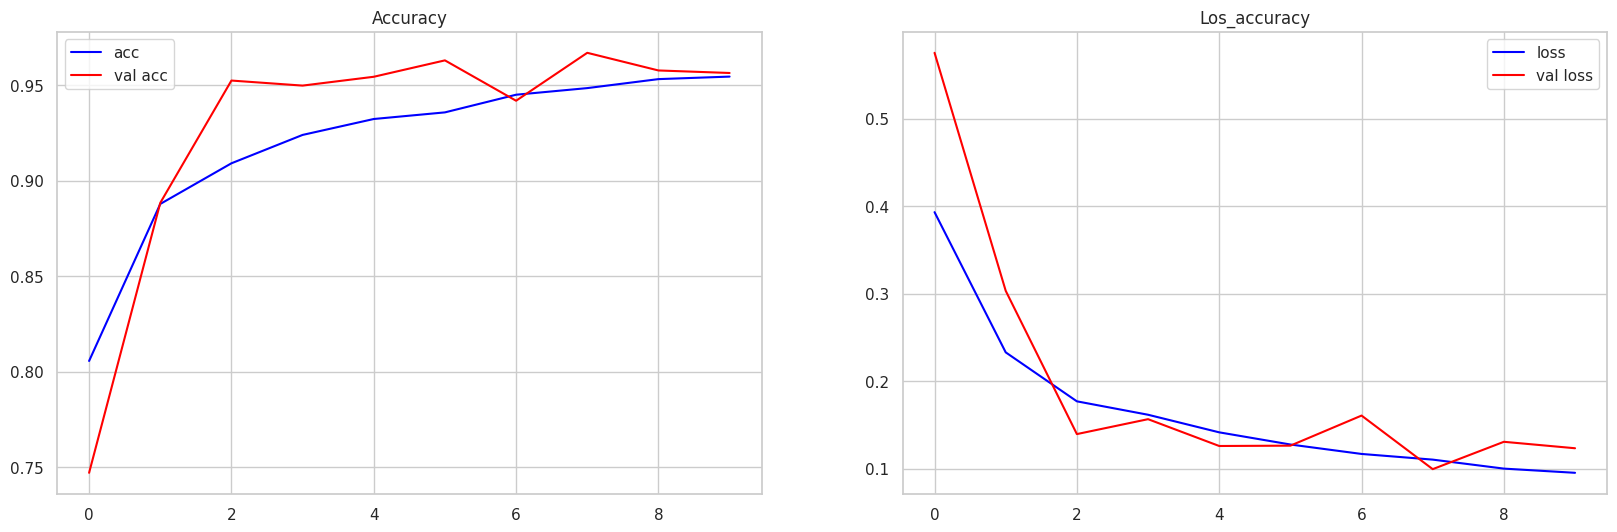

In [12]:
epoch_viewer(history)

In [13]:
true_labels = valid_gen.classes

# Prédictions
pred_probs = model.predict(valid_gen)
pred_labels = np.argmax(pred_probs, axis=1)

# Sauvegarde du modèle
model.save("resnet_base_model.h5")

# Rapport
target_names = list(valid_gen.class_indices.keys())
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=target_names))

95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step
Classification Report:

                 precision    recall  f1-score   support

          COVID       0.96      0.93      0.95       361
         Normal       0.97      0.98      0.98      1019
Viral Pneumonia       0.94      0.97      0.95       135

       accuracy                           0.97      1515
      macro avg       0.96      0.96      0.96      1515
   weighted avg       0.97      0.97      0.97      1515



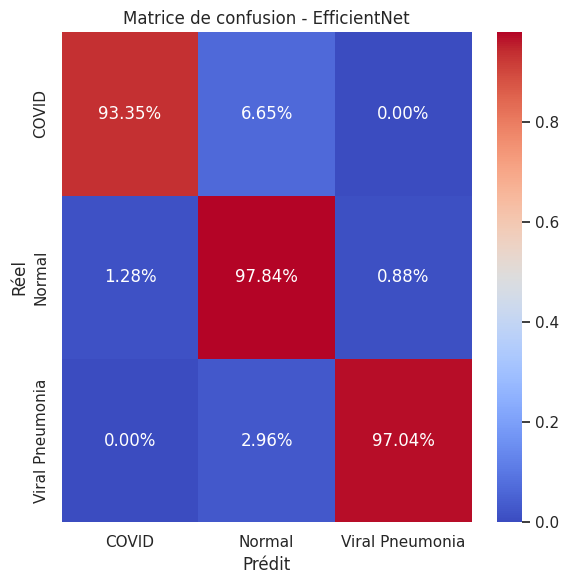

In [14]:
cm = confusion_matrix(true_labels, pred_labels)
labels = target_names

plot_confusion_matrix(cm, labels, normalize=True, title="Matrice de confusion - EfficientNet", cmap="coolwarm")

In [15]:
def build_resnet_tuner(hp):
    input_shape = (240, 240, 3)
    num_classes = 3  # Adjust as needed

    inputs = Input(shape=input_shape)

    # Base model with input_tensor, keeping all internal layers visible
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs
    )
    base_model.trainable = hp.Boolean("fine_tune", default=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    # Dense block with tunable units and dropout
    x = Dense(
        hp.Int("dense_units_1", min_value=256, max_value=1024, step=128),
        activation='relu'
    )(x)
    x = Dropout(hp.Float("dropout_1", 0.2, 0.5, step=0.1))(x)

    x = Dense(
        hp.Int("dense_units_2", min_value=128, max_value=512, step=64),
        activation='relu'
    )(x)
    x = Dropout(hp.Float("dropout_2", 0.2, 0.5, step=0.1))(x)

    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice("lr", values=[1e-2, 1e-3, 1e-4])
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [18]:
tuner = Hyperband(
    build_resnet_tuner,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='resnet_tuning',
    project_name='resnet50_covid'
)


In [19]:
tuner.search(train_gen, validation_data=valid_gen, epochs=10)

Trial 30 Complete [00h 09m 19s]
val_accuracy: 0.9735973477363586

Best val_accuracy So Far: 0.9828382730484009
Total elapsed time: 03h 07m 08s


In [20]:
best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hps)

In [21]:
best_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [22]:
epochs = 20

early_stopping = EarlyStopping(patience=5, min_delta=0.0005, mode="min", monitor="val_loss", restore_best_weights=True)

reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss", patience=3, min_delta=0.01, factor=0.1, cooldown=4)

train_labels = train_gen.classes
class_labels = np.unique(train_labels) 
class_weights = class_weight.compute_class_weight("balanced", classes=class_labels, y=train_labels)
class_weights_dict = dict(zip(class_labels, class_weights))

history = best_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_learning_rate]
)


Epoch 1/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 239s 227ms/step - accuracy: 0.8093 - loss: 0.3951 - val_accuracy: 0.8257 - val_loss: 0.6082 - learning_rate: 1.0000e-04
Epoch 2/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 148s 195ms/step - accuracy: 0.9452 - loss: 0.1276 - val_accuracy: 0.9228 - val_loss: 0.3098 - learning_rate: 1.0000e-04
Epoch 3/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 154s 204ms/step - accuracy: 0.9540 - loss: 0.1179 - val_accuracy: 0.7340 - val_loss: 0.8186 - learning_rate: 1.0000e-04
Epoch 4/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 147s 194ms/step - accuracy: 0.9613 - loss: 0.0924 - val_accuracy: 0.9340 - val_loss: 0.2214 - learning_rate: 1.0000e-04
Epoch 5/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 148s 195ms/step - accuracy: 0.9708 - loss: 0.0678 - val_accuracy: 0.9195 - val_loss: 0.2483 - learning_rate: 1.0000e-04
Epoch 6/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 148s 195ms/step - accuracy: 0.9781 - loss: 0.0541 - val_accuracy: 0.7479 - val_loss: 2.3812 - learning_rate: 1.0000e-04
Epoch 7/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

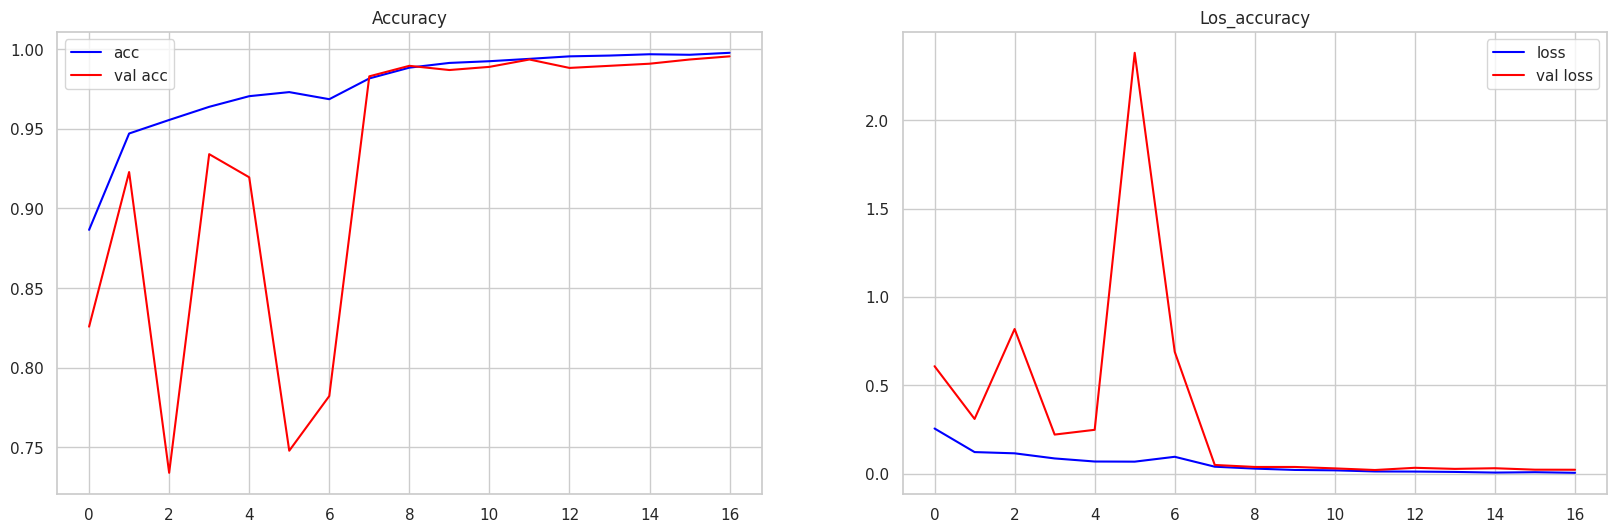

In [23]:
epoch_viewer(history)

In [25]:
true_labels = valid_gen.classes

# Prédictions
pred_probs = best_model.predict(valid_gen)
pred_labels = np.argmax(pred_probs, axis=1)

# Sauvegarde du modèle
best_model.save("resnet_base_model.h5")

# Rapport
target_names = list(valid_gen.class_indices.keys())
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=target_names, digits=4))

95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step
Classification Report:

                 precision    recall  f1-score   support

          COVID     0.9890    0.9917    0.9903       361
         Normal     0.9970    0.9941    0.9956      1019
Viral Pneumonia     0.9781    0.9926    0.9853       135

       accuracy                         0.9934      1515
      macro avg     0.9880    0.9928    0.9904      1515
   weighted avg     0.9934    0.9934    0.9934      1515



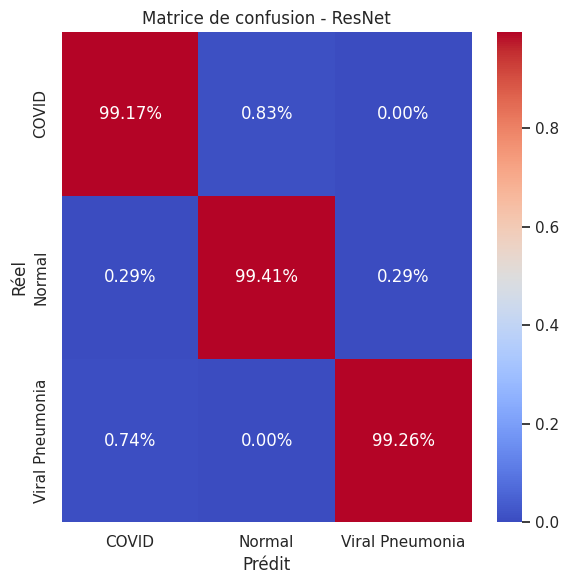

In [26]:
cm = confusion_matrix(true_labels, pred_labels)
labels = target_names

plot_confusion_matrix(cm, labels, normalize=True, title="Matrice de confusion - ResNet", cmap="coolwarm")

In [27]:
early_stopping = EarlyStopping(patience=5, min_delta=0.0005, mode="min", monitor="val_loss", restore_best_weights=True)

reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss", patience=3, min_delta=0.01, factor=0.1, cooldown=4)

train_labels = train_gen.classes
class_labels = np.unique(train_labels) 
class_weights = class_weight.compute_class_weight("balanced", classes=class_labels, y=train_labels)
class_weights_dict = dict(zip(class_labels, class_weights))

for layer in best_model.layers[:-50]:
    layer.trainable = False
for layer in best_model.layers[-50:]:
    layer.trainable = True
    
best_model.compile(
    optimizer=Adam(learning_rate=1e-5),  
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_finetune = best_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_learning_rate]
)

Epoch 1/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 115s 118ms/step - accuracy: 0.9940 - loss: 0.0133 - val_accuracy: 0.9927 - val_loss: 0.0219 - learning_rate: 1.0000e-05
Epoch 2/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 76s 100ms/step - accuracy: 0.9973 - loss: 0.0059 - val_accuracy: 0.9934 - val_loss: 0.0230 - learning_rate: 1.0000e-05
Epoch 3/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 77s 101ms/step - accuracy: 0.9972 - loss: 0.0065 - val_accuracy: 0.9934 - val_loss: 0.0248 - learning_rate: 1.0000e-05
Epoch 4/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 74s 98ms/step - accuracy: 0.9977 - loss: 0.0052 - val_accuracy: 0.9947 - val_loss: 0.0260 - learning_rate: 1.0000e-05
Epoch 5/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 74s 98ms/step - accuracy: 0.9983 - loss: 0.0049 - val_accuracy: 0.9947 - val_loss: 0.0255 - learning_rate: 1.0000e-06
Epoch 6/20
758/758 ━━━━━━━━━━━━━━━━━━━━ 74s 98ms/step - accuracy: 0.9988 - loss: 0.0034 - val_accuracy: 0.9947 - val_loss: 0.0260 - learning_rate: 1.0000e-06


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

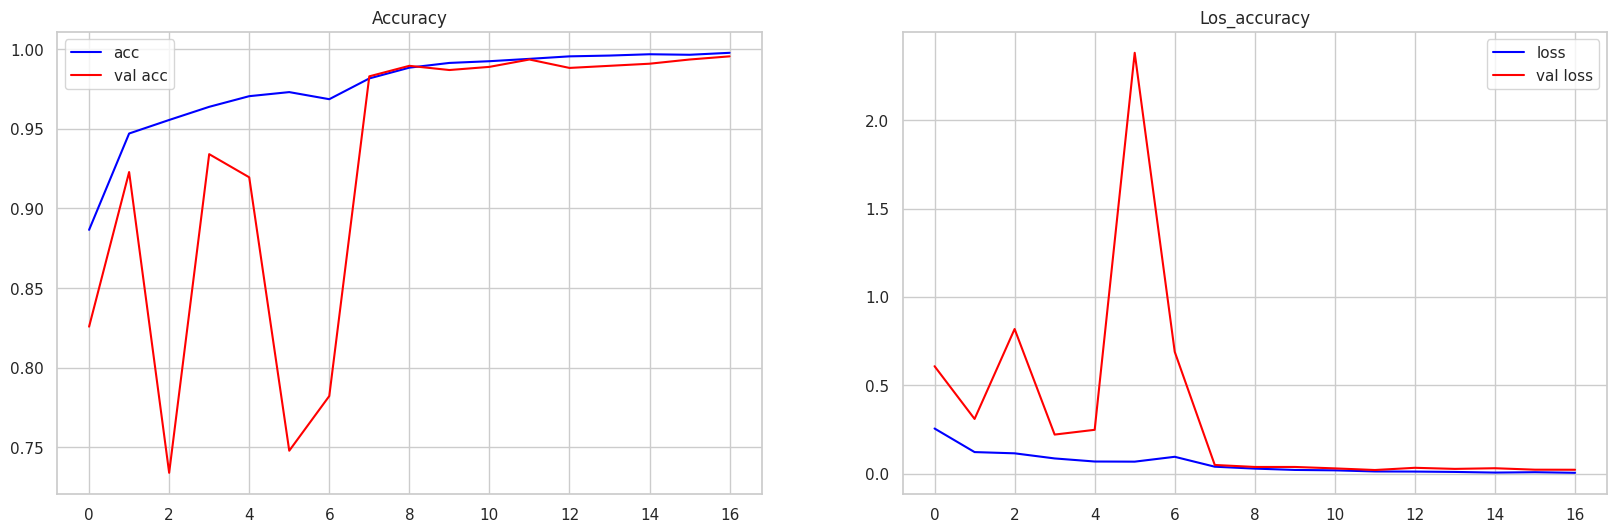

In [28]:
epoch_viewer(history)

In [29]:
true_labels = valid_gen.classes

# Prédictions
pred_probs = best_model.predict(valid_gen)
pred_labels = np.argmax(pred_probs, axis=1)

# Sauvegarde du modèle
best_model.save("resnet_base_model.h5")

# Rapport
target_names = list(valid_gen.class_indices.keys())
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=target_names, digits=4))

95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step
Classification Report:

                 precision    recall  f1-score   support

          COVID     0.9944    0.9834    0.9889       361
         Normal     0.9922    0.9971    0.9946      1019
Viral Pneumonia     0.9925    0.9852    0.9888       135

       accuracy                         0.9927      1515
      macro avg     0.9930    0.9885    0.9908      1515
   weighted avg     0.9927    0.9927    0.9927      1515



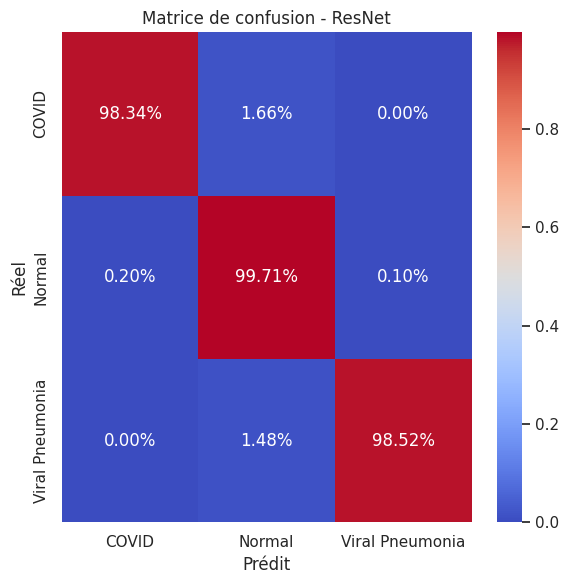

In [30]:
cm = confusion_matrix(true_labels, pred_labels)
labels = target_names

plot_confusion_matrix(cm, labels, normalize=True, title="Matrice de confusion - ResNet", cmap="coolwarm")